# General Trends in Anomalies

In [1]:
import os
# Set environment variables to disable multithreading
# as users will probably want to set the number of cores
# to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [21]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from anomaly.utils import specobjid_to_idx
from autoencoders.ae import AutoEncoder
from sdss.metadata import MetaData

meta = MetaData()

# Custom functions

In [54]:
def get_weights_per_segments(
    weights: np.ndarray,
    n_segments: int
) -> np.ndarray:
    """
    Compress explanation weights by averaging over fixed segments.

    Parameters
    ----------
    weights : np.ndarray
        Array of shape (n_samples, n_wavelengths) containing the explanation weights.
    n_segments : int
        Number of segments to divide the wavelength grid into.

    Returns
    -------
    weights_per_segment : np.ndarray
        Compressed array of shape (n_samples, n_segments) where each column
        corresponds to the average weight over a segment.
    """
    n_samples, n_wavelengths = weights.shape

    base_size, residual_size = divmod(n_wavelengths, n_segments)

    if residual_size > 0:
        n_segments += 1

    # Create empty array
    weights_per_segment = np.empty((n_samples, n_segments))

    for i in range(n_segments):
        if i < n_segments - 1:
            start = i * base_size
            end = (i + 1) * base_size
        else:
            start = base_size * (n_segments - 1)
            end = n_wavelengths

        # Fill by averaging over the segment
        weights_per_segment[:, i] = weights[:, start:end].mean(axis=1)

    return weights_per_segment

def clustering_inertias_silhouette(X, n_clusters=10):
    """

    """
    inertias = []
    silhouette_scores = []
    n_clusters_range = range(2, n_clusters)

    start_time = time.perf_counter()
    # Fit the k-means model
    for n in n_clusters_range:
        kmeans = KMeans(n_clusters=n, random_state=0)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
        # print(f"n: {n}, inertia: {kmeans.inertia_}", end="\r")
    finish_time = time.perf_counter()
    print(f"Run time: {finish_time - start_time:.2f} seconds")

    return inertias, silhouette_scores


# Data ingestion

In [3]:
bin_id = "bin_03"
phd_dir = "/home/elom/phd"
spectra_dir = f"{phd_dir}/00_phd_code/spectra"
explanations_dir = f"{phd_dir}/00_phd_code/explanations"
paper_figures_dir = f"{phd_dir}/00_paper_explain-me-why/sections/figures/"

In [4]:
meta_data_df = pd.read_csv(
    f"{spectra_dir}/0_01_z_0_5_4_0_snr_inf.csv.gz",
    index_col="specobjid",
)

wave = np.load(f"{spectra_dir}/wave_spectra_imputed.npy")

spectra = np.load(
    f"{spectra_dir}/spectra_imputed.npy",
    mmap_mode="r"
)

bin_idx_id_map = np.load(
    f"{spectra_dir}/{bin_id}/{bin_id}_index_specobjid.npy"
)

# MSE

In [ ]:
score_name = "mse_noRel100"
explanation_run_id = "20250427190650_uniform_5000_scale"


anomalies_array = np.load(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.npy",
    mmap_mode="r"
)

anomalies_df = pd.read_csv(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.csv.gz",
    index_col="specobjid",
)

weights = np.load(
    f"{explanations_dir}/{bin_id}/{score_name}/weights_{explanation_run_id}.npy",
)

Run time: 31.38 seconds


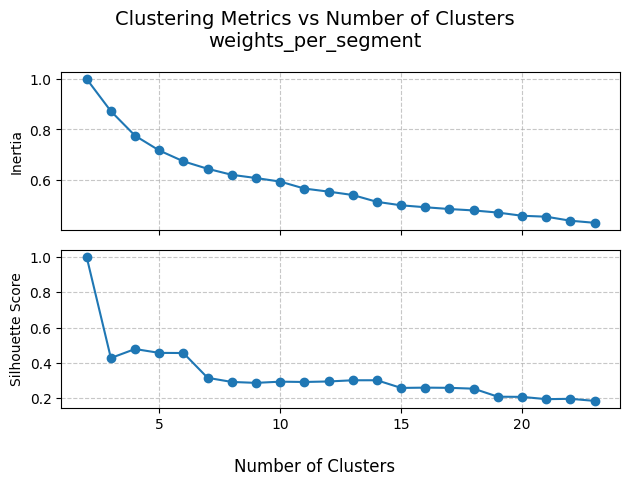

In [57]:
weights_per_segment = get_weights_per_segments(weights=weights, n_segments=128)
# Create a list to store the evaluation metric values
X = weights_per_segment
n_clusters = 24

inertias, silhouette_scores = clustering_inertias_silhouette(
    X=X, n_clusters=n_clusters
)

inertias = np.array(inertias) / np.max(inertias)
silhouette_scores = np.array(silhouette_scores) \
    / np.max(silhouette_scores)

fig, axs = plt.subplots(2, 1, figsize=None, sharex=True)
axs[0].plot(range(2, n_clusters), inertias, '-o')
axs[1].plot(range(2, n_clusters), silhouette_scores, '-o')
# Add grid to each axis
for ax in axs:
    ax.grid(True, axis='both', linestyle='--', alpha=0.7)
# Add labels
axs[0].set_ylabel("Inertia")
axs[1].set_ylabel("Silhouette Score")

# Shared x-label and title
fig.supxlabel("Number of Clusters")
fig.suptitle(
    "Clustering Metrics vs Number of Clusters\nweights_per_segment",
    fontsize=14
)

plt.tight_layout()
plt.show()

Run time: 32.61 seconds


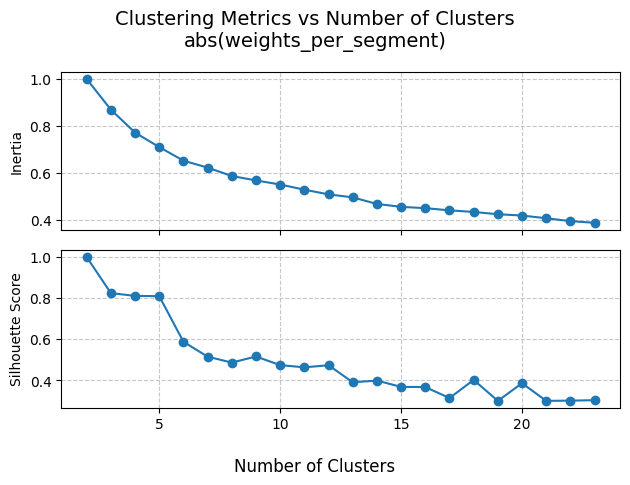

In [56]:
weights_per_segment = get_weights_per_segments(weights=weights, n_segments=128)
# Create a list to store the evaluation metric values
X = np.abs(weights_per_segment)
n_clusters = 24

inertias, silhouette_scores = clustering_inertias_silhouette(
    X=X, n_clusters=n_clusters
)

inertias = np.array(inertias) / np.max(inertias)
silhouette_scores = np.array(silhouette_scores) \
    / np.max(silhouette_scores)

fig, axs = plt.subplots(2, 1, figsize=None, sharex=True)
axs[0].plot(range(2, n_clusters), inertias, '-o')
axs[1].plot(range(2, n_clusters), silhouette_scores, '-o')
# Add grid to each axis
for ax in axs:
    ax.grid(True, axis='both', linestyle='--', alpha=0.7)
# Add labels
axs[0].set_ylabel("Inertia")
axs[1].set_ylabel("Silhouette Score")

# Shared x-label and title
fig.supxlabel("Number of Clusters")
fig.suptitle(
    "Clustering Metrics vs Number of Clusters\nabs(weights_per_segment)",
    fontsize=14
)

plt.tight_layout()
plt.show()

Run time: 29.72 seconds


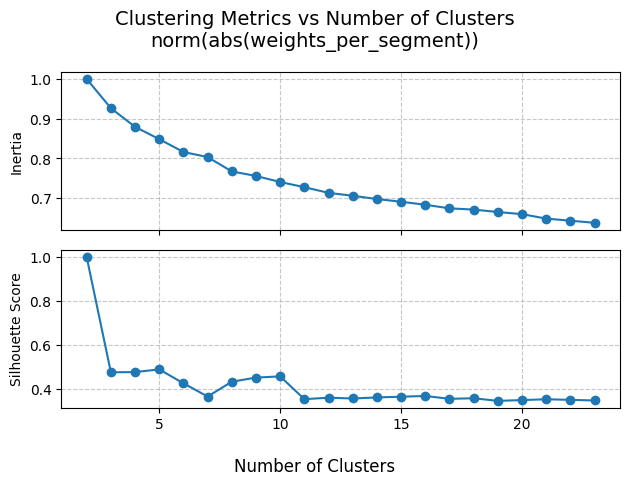

In [58]:
weights_per_segment = get_weights_per_segments(weights=weights, n_segments=128)
# Create a list to store the evaluation metric values
X = np.abs(weights_per_segment)/np.max(np.abs(weights_per_segment), axis=1, keepdims=True)
n_clusters = 24

inertias, silhouette_scores = clustering_inertias_silhouette(
    X=X, n_clusters=n_clusters
)

inertias = np.array(inertias) / np.max(inertias)
silhouette_scores = np.array(silhouette_scores) \
    / np.max(silhouette_scores)

fig, axs = plt.subplots(2, 1, figsize=None, sharex=True)
axs[0].plot(range(2, n_clusters), inertias, '-o')
axs[1].plot(range(2, n_clusters), silhouette_scores, '-o')
# Add grid to each axis
for ax in axs:
    ax.grid(True, axis='both', linestyle='--', alpha=0.7)
# Add labels
axs[0].set_ylabel("Inertia")
axs[1].set_ylabel("Silhouette Score")

# Shared x-label and title
fig.supxlabel("Number of Clusters")
fig.suptitle(
    "Clustering Metrics vs Number of Clusters\nnorm(abs(weights_per_segment))",
    fontsize=14
)

plt.tight_layout()
plt.show()

Run time: 166.51 seconds


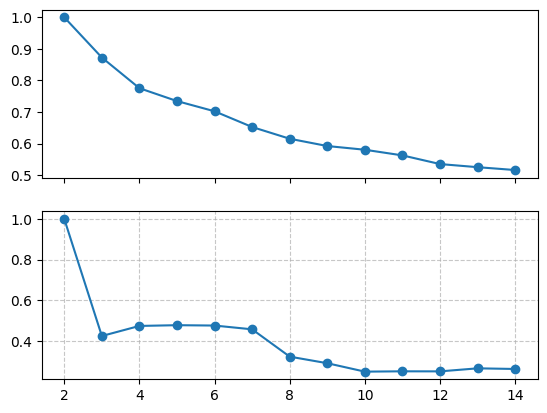

In [ ]:
# Create a list to store the evaluation metric values
X = weights
n_clusters = 12
inertias, silhouette_scores = clustering_inertias_silhouette(X=X, n_clusters=n_clusters)
inertias = np.array(inertias) / np.max(inertias)
silhouette_scores = np.array(silhouette_scores) / np.max(silhouette_scores)

fig, axs = plt.subplots(2, 1, figsize=None, sharex=True)
axs[0].plot(range(2, n_clusters), inertias, '-o')
axs[1].plot(range(2, n_clusters), silhouette_scores, '-o')


Run time: 127.71 seconds


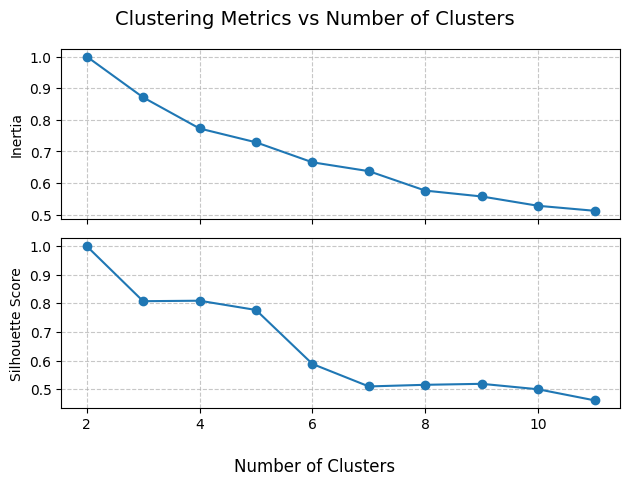

In [ ]:
# Create a list to store the evaluation metric values
X = np.abs(weights)
n_clusters = 12

inertias, silhouette_scores = clustering_inertias_silhouette(
    X=X, n_clusters=n_clusters
)

inertias = np.array(inertias) / np.max(inertias)
silhouette_scores = np.array(silhouette_scores) \
    / np.max(silhouette_scores)

fig, axs = plt.subplots(2, 1, figsize=None, sharex=True)
axs[0].plot(range(2, n_clusters), inertias, '-o')
axs[1].plot(range(2, n_clusters), silhouette_scores, '-o')
# Add grid to each axis
for ax in axs:
    ax.grid(True, axis='both', linestyle='--', alpha=0.7)
# Add labels
axs[0].set_ylabel("Inertia")
axs[1].set_ylabel("Silhouette Score")

# Shared x-label and title
fig.supxlabel("Number of Clusters")
fig.suptitle(
    "Clustering Metrics vs Number of Clusters",
    fontsize=14
)

plt.tight_layout()
plt.show()

Run time: 127.17 seconds


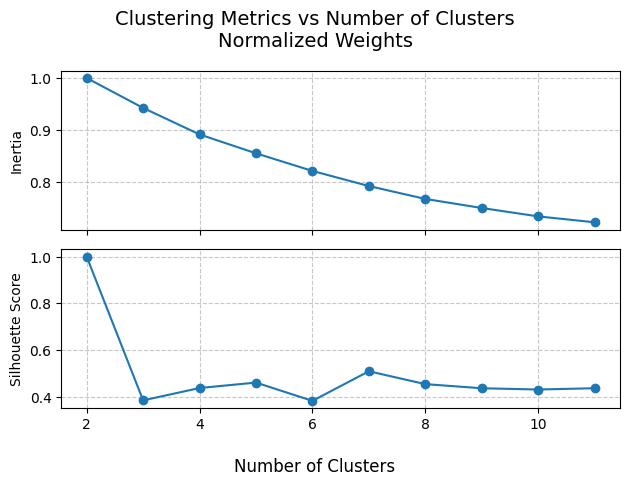

In [29]:
X = np.abs(weights)/np.max(np.abs(weights), axis=1, keepdims=True)
n_clusters = 12

inertias, silhouette_scores = clustering_inertias_silhouette(
    X=X, n_clusters=n_clusters
)

inertias = np.array(inertias) / np.max(inertias)
silhouette_scores = np.array(silhouette_scores) \
    / np.max(silhouette_scores)

fig, axs = plt.subplots(2, 1, figsize=None, sharex=True)
axs[0].plot(range(2, n_clusters), inertias, '-o')
axs[1].plot(range(2, n_clusters), silhouette_scores, '-o')
# Add grid to each axis
for ax in axs:
    ax.grid(True, axis='both', linestyle='--', alpha=0.7)
# Add labels
axs[0].set_ylabel("Inertia")
axs[1].set_ylabel("Silhouette Score")

# Shared x-label and title
fig.supxlabel("Number of Clusters")
fig.suptitle(
    "Clustering Metrics vs Number of Clusters\nNormalized Weights",
    fontsize=14
)

plt.tight_layout()
plt.show()

In [ ]:
number_segments = 128
segment_size, residual = divmod(wave.size, number_segments)
# segments = np.empty(spectra[:, :, 0].shape)

# for label_segment in range(number_segments):

#     start_segment = label_segment * segment_size
#     finish_segment = (label_segment + 1) * segment_size

#     segments[0, start_segment:finish_segment] = label_segment

# if residual != 0:
#     segments[0, finish_segment:] = number_segments

# return segments.astype(int)


(3773, 29, 3)

In [45]:
# Example dimensions
n_samples, n_wavelengths = weights.shape
n_segments = 129

# 1. Create empty array
weights_per_segment = np.empty((n_samples, n_segments))

base_size = 29  # fixed for first 128 segments
residual_size = 61  # special size for the last one

for i in range(n_segments):
    if i < n_segments - 1:
        start = i * base_size
        end = (i + 1) * base_size
    else:
        start = base_size * (n_segments - 1)
        end = n_wavelengths
    
    # Fill by averaging over the segment
    weights_per_segment[:, i] = weights[:, start:end].mean(axis=1)


In [47]:
weights_per_segment[:5, :2]

array([[ 0.00650745, -0.01333836],
       [ 0.03882496, -0.00044599],
       [-0.01468899,  0.01192801],
       [-0.01038193,  0.00444562],
       [ 0.00045811, -0.0002314 ]])

In [50]:
weights[:5, 40]

array([-0.01333836, -0.00044599,  0.01192801,  0.00444562, -0.0002314 ],
      dtype=float32)

## 